# ** Описание **

In [1]:
from __future__ import division

import base64
import csv
import gzip
import zlib
import sys
from importlib import reload
import numpy as np
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from collections import namedtuple

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
TRACE_NUM = 1000
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)

### Утилиты

#### Декораторы

In [3]:
def to_utf8(text):
    if isinstance(text, str): 
        text = text.encode('utf8')
    return text

def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, str): 
            try:
                text = text.decode('utf8')
            except UnicodeDecodeError:
                try:
                    text = text.decode('cp1251')
                except UnicodeDecodeError:
                    text = text.decode('koi8_r')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

#P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [4]:
from html.parser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = []
        self._a = []
        self._in_title = False
        self._in_a = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')
            if self._in_title:
                self._title.append(text + ' ')
            if self._in_a:
                self._a.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True
        elif tag == 'a':
            self._in_a = True

    def handle_endtag(self, tag):
        if tag == 'title':
            self._in_title = False
        elif tag == 'a':
            self._in_a = False

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip(), ''.join(self._title).strip(), ''.join(self._a).strip()

@convert2unicode
def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return parser.text()

#### Извлечение текста при помощи дополнительных библиотек

In [5]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Выбираем какой метод для конвертации html в текст будет основным

In [6]:
#html2text = html2text_bs
html2text = html2text_parser

#### Методы для токенизации текста

In [7]:
@convert2lower
@convert2unicode
def easy_tokenizer(text):
    word = str()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = str()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

@convert2lower
@convert2unicode
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [8]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    text, title, a = to_text(raw_html)
    text = tokenizer(text.lower())
    title = tokenizer(title.lower())
    a = tokenizer(a.lower())
    return text, title, a

#### Рассчет финальных метрик

In [9]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a / b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print('threshold %s' % threshold)
            print('\tclass_prec %s, class_recall %s, class_F1 %s' % r[0])
            print('\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1])
            print('\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2))
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [10]:
def calc_features(url, html_data):
    words, title, a = html2word(html_data)
    words = list(words)
    title = list(title)
    a = list(a)
    words_num = len(words)
    avg_word_len = 0
    title_words_num = len(title)    
    anchor_words_num = len(a)
    compression_level = 0
    
    for word in words:
        avg_word_len += len(word)
    avg_word_len /= words_num
    
    text = ' '.join(words)
    compr = zlib.compress(bytes(text.encode()))
    compression_level = safe_divide(sys.getsizeof(text), sys.getsizeof(compr))
    
    return [words_num, avg_word_len, title_words_num, anchor_words_num, compression_level, ' '.join(words), ' '.join(title), ' '.join(a)]

In [11]:
test_html_data = u'''
<html>
<title> Заголовок Ololo </title>
спам 1 2 3
<a>
spam.com
</a>
</html>
'''
test_url = 'http://ololo'
test_features = calc_features(test_url, test_html_data)
print(test_features)

[8, 3.5, 2, 2, 1.6941176470588235, 'заголовок ololo спам 1 2 3 spam com', 'заголовок ololo', 'spam com']


In [12]:
DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

def load_csv(train_input_file_name, test_input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    train_docs = []
    test_docs = []
    # if input_file_name.endswith('gz') else open(input_file_name) :            
    with gzip.open(train_input_file_name) as input_file: 
        headers = input_file.readline()
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().split(b'\t')
            url_id = int(parts[0])
            mark = bool(int(parts[1]))
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            features = calc_features_f(url, html_data)
            train_docs.append(DocItem(url_id, mark, url, features))
                     
    with gzip.open(test_input_file_name) as input_file: 
        headers = input_file.readline()
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().split(b'\t')
            url_id = int(parts[0])
            mark = bool(int(parts[1]))
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            features = calc_features_f(url, html_data)
            test_docs.append(DocItem(url_id, mark, url, features))
        
    return train_docs, test_docs

In [31]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_features=1000)

def get_features(train_row, test_row):
    train_words = []
    test_words = []
    train_title = []
    test_title = []
    train_a = []
    test_a = []
    train_docs = []
    test_docs = []
    for doc in train_row:
        train_words.append(doc.features[-3])
        train_title.append(doc.features[-2])
        train_a.append(doc.features[-1])
    for doc in test_row:
        test_words.append(doc.features[-3])
        test_title.append(doc.features[-2])
        test_a.append(doc.features[-1])
        
    vectorizer.fit(train_words + test_words)
    train_tfidf = vectorizer.transform(train_words)
    test_tfidf = vectorizer.transform(test_words)
            
    for i in range(len(train_words)):
        train_docs.append(DocItem(train_row[i].doc_id, train_row[i].is_spam,
                          train_row[i].url,
                          train_tfidf[i].todense().tolist()[0]))
                         # train_row[i].features[:-3] + train_tfidf[i].todense().tolist()[0]))
        #features[i] = tfidf[i].todense().tolist()[0]
        
    for i in range(len(test_words)):
        test_docs.append(DocItem(test_row[i].doc_id, test_row[i].is_spam,
                         test_row[i].url,
                         test_tfidf[i].todense().tolist()[0]))
        #features[i] = tfidf[i].todense().tolist()[0]
    
    return train_docs, test_docs

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

In [15]:
%%time

TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv.gz'
TEST_DATA_FILE  = 'kaggle_test_data_tab.csv.gz'

train_row, test_row = load_csv(TRAIN_DATA_FILE, TEST_DATA_FILE, calc_features)

00:30:13 INFO:Complete items 00000
00:31:07 INFO:Complete items 01000
00:31:53 INFO:Complete items 02000
00:32:40 INFO:Complete items 03000
00:33:25 INFO:Complete items 04000
00:34:15 INFO:Complete items 05000
00:35:01 INFO:Complete items 06000
00:35:51 INFO:Complete items 07000
00:35:53 INFO:Complete items 00000
00:37:03 INFO:Complete items 01000
00:38:07 INFO:Complete items 02000
00:39:05 INFO:Complete items 03000
00:39:58 INFO:Complete items 04000
00:40:48 INFO:Complete items 05000
00:41:50 INFO:Complete items 06000
00:42:42 INFO:Complete items 07000
00:43:37 INFO:Complete items 08000
00:44:32 INFO:Complete items 09000
00:45:46 INFO:Complete items 10000
00:46:38 INFO:Complete items 11000
00:47:33 INFO:Complete items 12000
00:48:23 INFO:Complete items 13000
00:49:21 INFO:Complete items 14000
00:50:18 INFO:Complete items 15000
00:51:19 INFO:Complete items 16000


CPU times: user 21min 4s, sys: 3.37 s, total: 21min 8s
Wall time: 21min 8s


In [16]:
len(train_row[2].features)

8

In [32]:
%%time

train_docs, test_docs = get_features(train_row, test_row)

CPU times: user 3min 19s, sys: 2.13 s, total: 3min 21s
Wall time: 3min 21s


In [33]:
len(train_docs[2].features)

1000

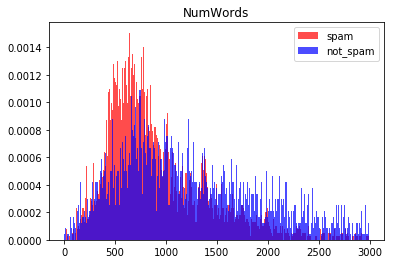

In [37]:
is_spam_data = [doc.features[0] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[0] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWords')
plt.legend()
plt.show()

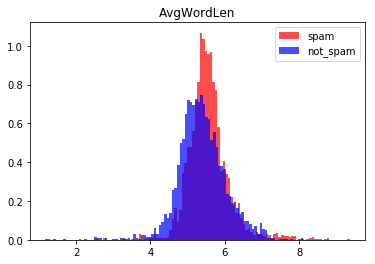

In [38]:
is_spam_data = [doc.features[1] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[1] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('AvgWordLen')
plt.legend()
plt.show()

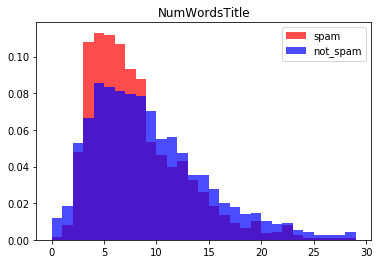

In [39]:
is_spam_data = [doc.features[2] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[2] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWordsTitle')
plt.legend()
plt.show()

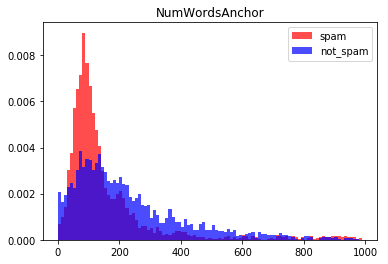

In [40]:
is_spam_data = [doc.features[3] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[3] for doc in train_docs if doc[1] == False]
bins = range(0, 1000, 10)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWordsAnchor')
plt.legend()
plt.show()

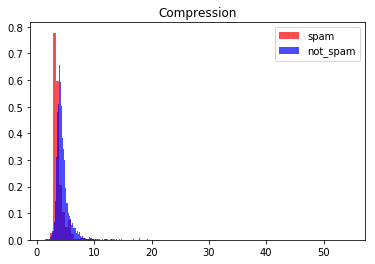

In [41]:
is_spam_data = [doc.features[4] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[4] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('Compression')
plt.legend()
plt.show()

** Классификатор: **
Нужно реализовать

In [28]:
from IPython.display import clear_output

def train(network, train_loader, test_loader, epochs, learning_rate, ravel_init=False, optim=torch.optim.Adam):
    loss = nn.BCELoss()
    optimizer = optim(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            network.train()
            for X, y in train_loader:
                if ravel_init:
                    X = X.view(X.size(0), -1)
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append(((prediction.data.numpy() > 0.5)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []  
            network.eval()
            for X, y in test_loader:
                if ravel_init:
                    X = X.view(X.size(0), -1)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append(((prediction.data.numpy() > 0.5)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) BCE: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [20]:
class MyDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.Y[i]

In [25]:
class Classifier:
    
    def __init__(self, epochs=50, lr=0.00001):
        self.epochs = epochs
        self.lr = lr

    def predict(self, doc):
        X = np.zeros((len(doc.features)))
        X[:] = doc.features
        return self.model(torch.from_numpy(X)).data.numpy()[0]
    
    def predict_all(self, docs):
        res = []
        for doc_num, doc in enumerate(docs):
            trace(doc_num)
            prediction = self.predict(doc)            
            res.append( (doc.doc_id, doc.is_spam, doc.url, prediction) )
        return res
    
    def train(self, docs):
        X = np.zeros((len(docs), len(docs[0].features)))
        y = np.zeros(len(docs))
        for doc_num, doc in enumerate(docs):                            
            X[doc_num] = doc.features
            y[doc_num] = doc.is_spam
        self.model = nn.Sequential(
            nn.Linear(len(docs[0].features), 300),
            nn.ReLU(inplace=True),
            nn.Linear(300, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid()).double()
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.1, random_state=42)
        train_set = MyDataset(X_train, y_train)
        test_set = MyDataset(X_test, y_test)
        train_loader = DataLoader(train_set, batch_size=64)
        test_loader = DataLoader(test_set, batch_size=64)
        train(self.model, train_loader, test_loader, epochs=self.epochs, learning_rate=self.lr)

Epoch 31... (Train/Test) BCE: 0.066/0.114	Accuracy: 0.523/0.559


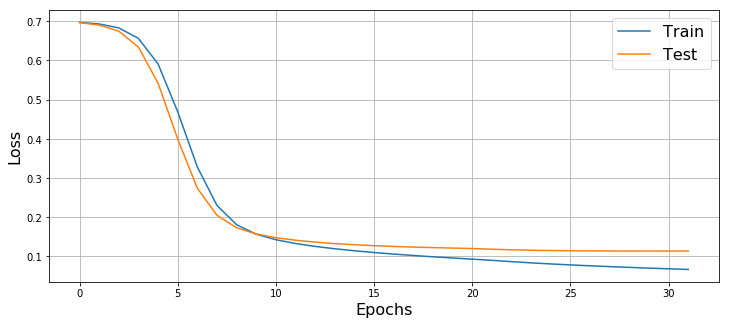

In [34]:
classifier = Classifier(epochs=1000, lr=0.00002)
classifier.train(train_docs)

In [ ]:
#Посмотреть, что предсказывается для тестового html
#classifier.predict(DocItem(0, 0, test_url , test_features))

** Рисуем графики **

01:39:34 INFO:Complete items 00000
01:39:36 INFO:Complete items 01000
01:39:38 INFO:Complete items 02000
01:39:41 INFO:Complete items 03000
01:39:43 INFO:Complete items 04000
01:39:45 INFO:Complete items 05000
01:39:47 INFO:Complete items 06000
01:39:49 INFO:Complete items 07000


threshold 0
	class_prec 0.5833333333333334, class_recall 1.0, class_F1 0.7368421052631579
	not_class_prec 0.0, not_class_recall 0.0, not_class_F1 0.0
		MacroF1Mesure 0.3684210526315789
threshold 0.01
	class_prec 0.787977722296908, class_recall 0.9985397907033341, class_F1 0.8808501502790896
	not_class_prec 0.9967338051170387, not_class_recall 0.6238500851788756, not_class_F1 0.7673931265716681
		MacroF1Mesure 0.8241216384253789
threshold 0.02
	class_prec 0.8378654671846248, class_recall 0.9973229496227792, class_F1 0.9106666666666665
	not_class_prec 0.9948908499767766, not_class_recall 0.7298126064735946, not_class_F1 0.8419811320754718
		MacroF1Mesure 0.8763238993710691
threshold 0.03
	class_prec 0.8644711842938568, class_recall 0.9965928449744463, class_F1 0.925842188559801
	not_class_prec 0.9939315127871695, not_class_recall 0.7812606473594549, not_class_F1 0.874856924837848
		MacroF1Mesure 0.9003495566988245
threshold 0.04
	class_prec 0.8826827690317015, class_recall 0.996106108542

threshold 0.3300000000000001
	class_prec 0.9730445246690734, class_recall 0.9839376977366756, class_F1 0.978460793804453
	not_class_prec 0.9771547248182763, not_class_recall 0.9618398637137989, not_class_F1 0.9694368131868132
		MacroF1Mesure 0.9739488034956332
threshold 0.34000000000000014
	class_prec 0.9737412671645387, class_recall 0.9836943295205646, class_F1 0.9786924939467312
	not_class_prec 0.9768406498444522, not_class_recall 0.9628620102214651, not_class_F1 0.9698009608785175
		MacroF1Mesure 0.9742467274126243
threshold 0.35000000000000014
	class_prec 0.9746743849493488, class_recall 0.9834509613044536, class_F1 0.9790430042398547
	not_class_prec 0.9765355417529331, not_class_recall 0.9642248722316865, not_class_F1 0.9703411623521344
		MacroF1Mesure 0.9746920832959945
threshold 0.36000000000000015
	class_prec 0.9756038647342995, class_recall 0.9829642248722317, class_F1 0.9792702145714631
	not_class_prec 0.9758953168044077, not_class_recall 0.965587734241908, not_class_F1 0.970

threshold 0.6800000000000004
	class_prec 0.9910291552454523, class_recall 0.9678753954733512, class_F1 0.9793154395469097
	not_class_prec 0.9564500164962059, not_class_recall 0.9877342419080068, not_class_F1 0.9718404290982233
		MacroF1Mesure 0.9755779343225666
threshold 0.6900000000000004
	class_prec 0.9912609238451935, class_recall 0.9661718179605744, class_F1 0.9785555829430614
	not_class_prec 0.9542612701546561, not_class_recall 0.9880749574105622, not_class_F1 0.9708737864077669
		MacroF1Mesure 0.9747146846754142
threshold 0.7000000000000004
	class_prec 0.99175, class_recall 0.9654417133122414, class_F1 0.9784190405722037
	not_class_prec 0.9533508541392904, not_class_recall 0.9887563884156729, not_class_F1 0.9707308914534204
		MacroF1Mesure 0.974574966012812
threshold 0.7100000000000004
	class_prec 0.9917458729364682, class_recall 0.9649549768800195, class_F1 0.9781670161588751
	not_class_prec 0.9527248850952068, not_class_recall 0.9887563884156729, not_class_F1 0.9704062865741514

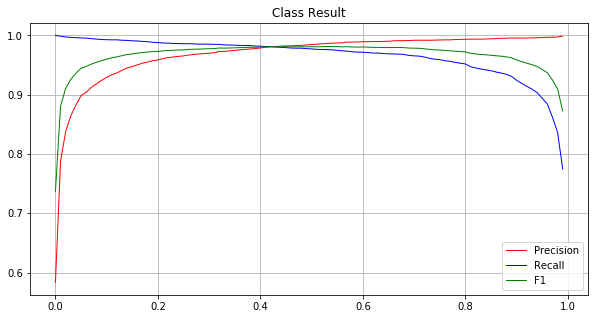

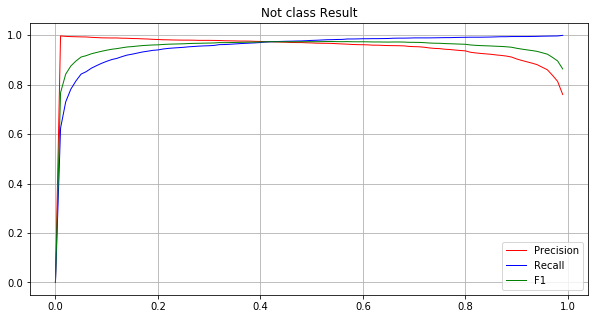

In [35]:
plot_results(train_docs, min_threshold=0, max_threshold=1, step=0.01, trace=1)

In [36]:
threshold = 0.6

with open('my_submission.csv', 'w') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id', 'Prediction'])
    for item in classifier.predict_all(test_docs):
        prediction =  1 if item[3] > threshold else 0
        writer.writerow([item[0], prediction])

01:44:35 INFO:Complete items 00000
01:44:37 INFO:Complete items 01000
01:44:39 INFO:Complete items 02000
01:44:41 INFO:Complete items 03000
01:44:43 INFO:Complete items 04000
01:44:45 INFO:Complete items 05000
01:44:47 INFO:Complete items 06000
01:44:49 INFO:Complete items 07000
01:44:51 INFO:Complete items 08000
01:44:53 INFO:Complete items 09000
01:44:55 INFO:Complete items 10000
01:44:58 INFO:Complete items 11000
01:45:00 INFO:Complete items 12000
01:45:02 INFO:Complete items 13000
01:45:04 INFO:Complete items 14000
01:45:06 INFO:Complete items 15000
01:45:08 INFO:Complete items 16000
